# SSD를 이용한 물체 검출
PyTorch기반으로 작성된 SSD를 이용한 물체 검출 코드 입니다. (Inference only)

In [77]:
import os
import sys

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

## SSD300 모델 가져오기 (참고: build_ssd func. in ssd.py)
1. 필요한 파라미터를 입력하여 SSD300 모델을 가져옵니다.
    + def build_ssd(phase, backbone='vgg16', size=300, num_classes=21)    
        + phase: test or train
        + size: 입력 영상 크기
        + num_classes: 물체 카테고리 수. PASCAL VOC 기준 20 class + 1 background
2. 미리 VOC0712 trainval 데이터셋에서 학습된 weights를 로드합니다.

In [2]:
net = build_ssd('vgg16', 300, 21)    # initialize SSD
net.load_weights('weights/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


## 영상 가져오기
VOC2007 dataset으로부터 sample 영상 한장을 가져옵니다.

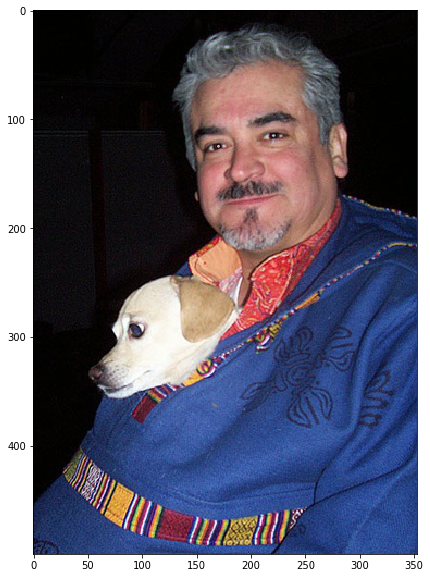

In [3]:
image = cv2.imread('data/000001.jpg', cv2.IMREAD_COLOR) 
# image = cv2.imread('data/000011.jpg', cv2.IMREAD_COLOR)
# image = cv2.imread('data/000014.jpg', cv2.IMREAD_COLOR)

%matplotlib inline
from matplotlib import pyplot as plt
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## 영상 전처리
CNN 학습 시에 적용된 영상 전처리 변환들을 적용해줍니다.     
    
    + Resize
    + Substract mean
    + Swap color channels (BGR to RGB)
    + ToTensor (H x W x C to C x H x W)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


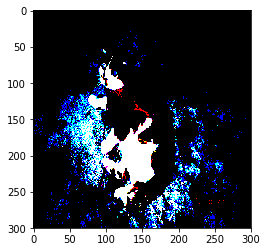

In [19]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## Forward propagation
현재 사용하고있는 SSD network는 B x C x H x W tensor를 입력으로 받는다고 가정합니다.<br />
(B: batch_size, C: channels, H: height, W: width)<br />
따라서 .unsqueeze(0) 을 통해 3 x 300 x 300 영상을 1 x 3 x 300 x 300 으로 변환해 줍니다.<br />
* xx = x.unsqueeze(0) 실행 전 후에 cell을 추가하고 (cell 선택을 해제 한 후, 단축키: A) x.shape 을 수행하여 확인.
* [Jupyter 단축키](https://ljs93kr.tistory.com/54) 참고

그리고나서, 영상을 network에 입력하고 forward propagation을 수행합니다.<br />
(torch.nn.module을 상속받은 class로부터 생성된 net은 net() 형태로 호출시에 forward가 수행됨.)

In [55]:
xx = x.unsqueeze(0)
if torch.cuda.is_available():
    xx = xx.cuda()
    
# At inference phase, we don't need to store intermediate varaiables which is used for backward propagation.
with torch.no_grad():    
    loc_pred, cls_pred, priors = net(xx)

priors = priors.type(type(xx))

## CNN 출력 해석 (Parse the detections)
1. Decode 함수 작성
SSD는 미리 정의된 default box(prior or anchor box)와 실제 영상에 있는 정답(ground truth)과의 변환 관계를 추론하도록 설계되었습니다.<br/>
따라서 SSD의 출력 결과를 bounding box로 변환하기 위해서는 Decode 함수가 필요합니다.<br/>

    * [TODO] 아래의 decode 함수 내부를 완성하여 네트워크의 출력을 bounding box로 변환하세요. (발표자료 61페이지 참고)
    * 함수 argument인 *prior_data* 는 기존 anchor box입니다; *loc_data* 는 SSD에서 출력된 상대좌표 입니다. *variances* 는 미리 정의된 anchor box의 center / size에 대한 스케일 입니다. 미리 정의된 prior_data와 variance, 그리고 SSD출력인 loc_data를 조합하여 새로운 box로 변환을 해야합니다.
      0. 변환은 주어진 anchor에 대한 변화(delta)를 구하는 과정입니다. 주의할 점은, SSD의 출력은 절대좌표(absolute scale)가 아니라 미리 정의된 anchor의 크기 (w, h) 및 variance에 비례한다는 점 입니다.
      1. 최종 출력은 (x_min, y_min, x_max, y_max)의 형태로 출력됩니다. 모든 계산은 pytorch tensor의 연산으로 수행합니다.
      2. 주어진 prior_data는 (x_center, y_center, width, height)의 정보이며, loc_data는 (rel_x, rel_y, rel_scale_w, rel_scale_h)입니다. 미리 정의된 variance는 (center_variance, size_variance)입니다.
      3. 최종 center x,y는 offset을 계산하여 더합니다. offset은 SSD의 출력, variance, 그리고 anchor size에 비례합니다. 계산 방법은 (rel_x, rel_y) * center_variance * (width, height)입니다.
      4. 최종 width, height는 scale을 계산하여 곱해줍니다. scale은 자연수 e를 밑으로 하고, (rel_scale_w, rel_scale_h) * scale_variance를 지수로 하는 exponential 결과입니다.
      5. 3/4번 과정을 거치면 (x, y, w, h)의 형태로 계산이 되는데, (x_min, y_min, x_max, y_max)의 형식으로 변환하여 반환합니다.

In [75]:
def decode(loc_data, prior_data):
    '''
        loc_data: P x 4 matrix (network prediction)
        prior_data: P x 4 matrix (default boxes)
    '''
    variances = [0.1, 0.2]
    
    ### TODO
    boxes = None
    
    return boxes


2. Decode 및 NMS(Non-maxima suppression)을 통한 최종 검출 결과 계산
    + [TODO] 위에서 작성한 Decode 함수와 주어진 NMS 함수를 이용하여 for loop 내부를 완성하세요.
    * NMS는 minibatch의 각 샘플의 각 클래스마다 한 번씩 수행합니다.
    * 최종 목적은 *output* 에 각 샘플 별, 각 클래스 별 예측된 박스를 confidence score와 함께 넣어주는 것 입니다. 주의할 점은, 각 샘플 별로 매우 많은 box prediction이 존재하기 때문에 이 box prediction을 NMS함수를 통해 소수의 대표성을 띄는 박스로 줄이는 것 입니다.
      0. 먼저 decode함수를 이용해서, inference결과를 anchor box (prior_data)와 조합하여 우리가 원하는 (min_x, min_y, max_x, max_y)형태의 box로 변환해줍니다.
      1. 각 box별 class confidence인 conf_data에서, 각 class 별로 conf_thresh보다 높은 값을 갖는 박스를 찾습니다.
      2. 조건에 맞는 박스들의 score 및 변환된 box를 모아서 nms함수에 넣어줍니다. 
        * nms함수는 top-k score를 갖고 겹치지 않는 박스의 index와 갯수를 반환합니다 (ids, count).
      3. output에 알맞게, nms를 통해 반환된 박스의 (confidence, x, y, w, h)를 넣어줍니다.

In [78]:
from layers.box_utils import nms
softmax = nn.Softmax(dim=-1)

print('shape of loc_pred: {}'.format(loc_pred.shape))    # {batch} X {# of default boxes} X {[tx, ty, tw, th]}
print('shape of cls_pred: {}'.format(cls_pred.shape))    # {batch} X {# of default boxes} X {# of classes}
print('shape of priors: {}'.format(priors.shape))        #           {# of default boxes} X {[Px, Py, Pw, Ph]}
        
loc_data   = loc_pred
conf_data  = softmax(cls_pred)
prior_data = priors

C           = 21 # number of categories. For PASCAL VOC, 21 (20classes + background).
top_k       = 200
conf_thresh = 0.1
nms_thresh  = 0.45

B = loc_data.size(0)   # batch size
P = prior_data.size(0)  # number of default boxes. For SSD300, it's 8732.

output = torch.zeros(B, C, top_k, 5)   # {batch} X {classes} X {top_k} X {[score, x, y, w, h]}
conf_data = conf_data.view(B, P, C).transpose(2, 1)        

# Decode predictions into bboxes.
for i in range(B):    
    
    ### TODO
    decoded_boxes = None
    
    # For each class, perform nms
    conf_scores = conf_data[i].clone()

    for cl in range(1, C):
        
        ### TODO
        c_mask = None
        
        if not c_mask.any():
            continue
            
        ### TODO
        scores = None
        l_mask = None
        boxes = None
        
        # idx of highest scoring and non-overlapping boxes per class
        ids, count = nms(boxes, scores, nms_thresh, top_k)
        
        ### TODO
        output[i, cl, :count] = None

print( '\nTop-3, detection results: \n{:}'.format(output[0, :, :3, :]) )



shape of loc_pred: torch.Size([1, 8732, 4])
shape of cls_pred: torch.Size([1, 8732, 21])
shape of priors: torch.Size([8732, 4])

Top-3, detection results: 
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 

## 검출 결과 그리기
계산된 최종 검출 결과 중 confidence가 ```score_thresh``` 이상인 결과들을 그려봅니다. 

   + [TODO] score_thresh를 바꿔가며 검출 결과를 그려보세요.

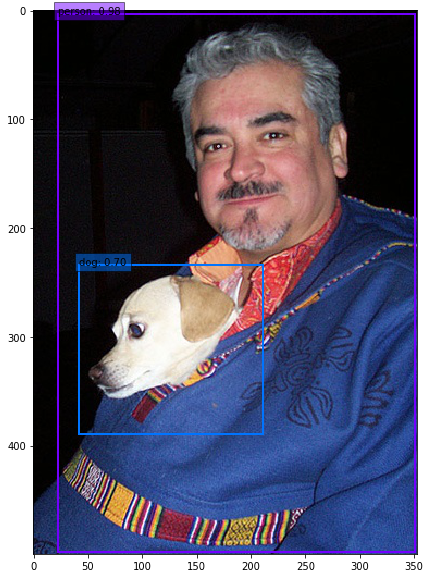

In [79]:
from data import VOC_CLASSES as labels

### TODO
score_thresh = 0.6

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = output.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= score_thresh:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1